## Cluster information analysis
This notebook analyzes the properties of the "clusters" representing cosmological objects (starts and galaxies) in the real images. Finding the clusters and extrating information about them takes some time, so we do it in a separate script. This notebook loads a dataframe which already contains raw information about the clusters found in the imaged from the scored data. We use this raw information dataframe to analyze the statistics and structure of the real images.

The columns of the dataframe are:
* *id*: the name of the image in the dataset
* *score*: the score of the image
* *background_threshold*: see common/image_processing.py, method estimate_background_intensity_threshold
* *cluster_num*: the number of clusters found in the image
* *cluster_sizes*: a list, the number of pixels in each cluster of the image
* *cluster_peak_intensities*: a list, the intensity of the center pixel for each cluster
* *cluster_num_intensities*: a list, the number of different intensities in each cluster
* *cluster_center*: a list, a pair representing the pixel location of the center of each cluster
* *num_zero_pixels*: the number of pitch black (zero intensity) pixels in the image

In [8]:
%reload_ext autoreload
%autoreload 2
import ast
import pickle
import itertools
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import swifter

import sys
sys.path.append('./..')
from analysis.generate_cluster_information_file import load_scored_info
from common.image_processing import pixel_intensity_histogram

#### Load dataframe with basic cluster information

In [12]:
df = load_scored_info(format='df')
df.head(5)

,score,background_threshold,cluster_num,cluster_sizes,cluster_peak_intensities,cluster_num_intensities,cluster_centers,num_zero_pixels
id,,,,,,,,
1002900,2.631728,0,50,"[144, 38, 24, 16, 5, 39, 17, 18, 26, 11, 56, 1...","[6, 6, 2, 2, 1, 8, 2, 1, 3, 1, 3, 2, 255, 2, 6...","[6, 6, 2, 2, 1, 7, 2, 1, 3, 1, 3, 2, 71, 2, 6,...","[(3, 524), (44, 425), (55, 321), (66, 400), (9...",998221
1003620,1.560731,0,104,"[28, 17, 8, 11, 45, 4, 14, 71, 1, 7, 2, 18, 11...","[4, 2, 1, 2, 9, 1, 2, 16, 1, 1, 1, 3, 1, 1, 1,...","[4, 2, 1, 2, 8, 1, 2, 14, 1, 1, 1, 3, 1, 1, 1,...","[(19, 375), (53, 839), (56, 524), (84, 208), (...",997074
1005208,3.137059,1,71,"[53, 27, 42, 6, 3, 15, 19, 45, 73, 115, 119, 6...","[12, 4, 9, 2, 2, 2, 3, 4, 9, 68, 78, 2, 2, 2, ...","[10, 3, 8, 1, 1, 1, 2, 3, 8, 31, 34, 1, 1, 1, ...","[(3, 582), (0, 715), (14, 83), (19, 614), (51,...",3
1005849,3.509851,2,49,"[1, 5, 61, 4, 80, 45, 68, 44, 10, 35, 28, 7, 3...","[3, 3, 12, 3, 69, 15, 12, 17, 3, 4, 5, 3, 3, 3...","[1, 1, 10, 1, 27, 8, 9, 13, 1, 2, 3, 1, 1, 1, ...","[(0, 906), (0, 949), (5, 508), (24, 591), (34,...",1
1006237,1.371129,0,169,"[3, 92, 6, 138, 16, 12, 142, 6, 31, 1, 11, 3, ...","[1, 179, 1, 255, 2, 1, 5, 1, 5, 1, 1, 1, 3, 1,...","[1, 41, 1, 47, 2, 1, 5, 1, 5, 1, 1, 1, 3, 1, 2...","[(0, 604), (2, 736), (13, 155), (26, 601), (22...",996531


#### Select only the real images 
Currently we heuristically choose a score of 2.0 as a threshold for 'real' images

In [21]:
real_images_df = df[df.score >= 2.0]
"Number of real images: ", real_images_df.shape[0]

('Number of real images: ', 2967)

In [ ]:
# pd saves lists as strings, so we need to convert them to lists manually
real_images_df.cluster_sizes = real_images_df.cluster_sizes.swifter.apply(ast.literal_eval)
real_images_df.cluster_centers = real_images_df.cluster_centers.swifter.apply(ast.literal_eval)
real_images_df.cluster_peak_intensities = real_images_df.cluster_peak_intensities.swifter.apply(ast.literal_eval)
real_images_df.cluster_num_intensities = real_images_df.cluster_num_intensities.swifter.apply(ast.literal_eval)

assert type(real_images_df.cluster_sizes.tolist()[0]) == list

real_images_df.head(10)

### Number of pitch black pixels
Our initial hyphotesis was that the background occupies the majority of the image pixels and that this background is mostly constant with an intensity of 0 (pitch black).

Our analysis shows that this assumption is correct for the majority of images. 79% of the real images have a background of exactly 0 intensity (more specifically, more than 80% of their pixels with intensity 0). However, the plots also show that the distribution is bi-modal: around 20% of the images contain < 10% intensity 0 pixels. This means that around 20% of the real images in the dataset have a non-zero background. More detailed exploration of this follows in the next cell.

Number of images with less than 10% intensity 0 pixels: 643 out of 2967
Number of images with more than 80% intensity 0 pixels: 2324 out of 2967


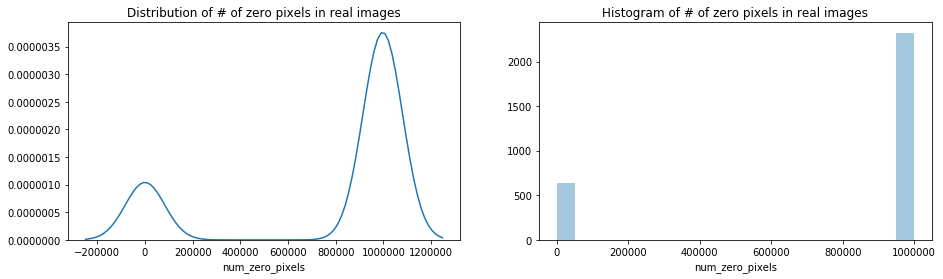

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)
num_zero_pixels = real_images_df.num_zero_pixels

plt.subplots_adjust(left=8.0, bottom=None, right=10.0, top=None, wspace=None, hspace=None)
sns.distplot(num_zero_pixels, hist=False, kde=True, ax=ax1)
sns.distplot(num_zero_pixels, hist=True, bins=20, kde=False, ax=ax2)
ax1.set_title('Distribution of # of zero pixels in real images')
ax2.set_title('Histogram of # of zero pixels in real images')
print("Number of images with less than 10% intensity 0 pixels: {} out of {}".format((num_zero_pixels < 100000).sum(), real_images_df.shape[0]))
print("Number of images with more than 80% intensity 0 pixels: {} out of {}".format((num_zero_pixels > 800000).sum(), real_images_df.shape[0]))

### Background intensity
Here we explore the results of an automated method to estimate the threshold for the background (see common/image_processing.py, method estimate_background_intensity_threshold).

**Result**: the majority of the images have a 0 intensity background (80% of the images). The other 20% have a background intensity of 1 or 2.

In [7]:
background_thresholds = real_images_df.background_threshold.tolist()
Counter(background_thresholds)

Counter({0: 2324, 1: 423, 2: 216, 3: 4})

Num zero background real images 2324


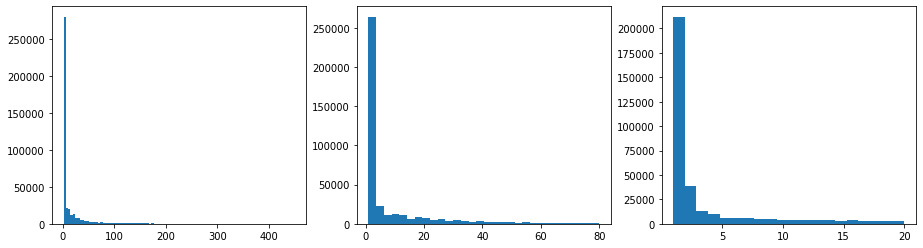

In [11]:
zero_background_df = real_images_df[real_images_df.background_threshold == 0]

print("Num zero background real images", zero_background_df.shape[0])
all_galaxy_sizes = list(itertools.chain.from_iterable(zero_background_df.cluster_sizes.tolist())) 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# fig.tight_layout()
plt.subplots_adjust(left=8.0, bottom=None, right=10.0, top=None, wspace=None, hspace=None)
ax1.hist(all_galaxy_sizes, bins=100, range=(1, 450))
ax2.hist(all_galaxy_sizes, bins=30, range=(1, 80))
ax3.hist(all_galaxy_sizes, bins=20, range=(1, 20))
plt.show()

Num one background real images 423


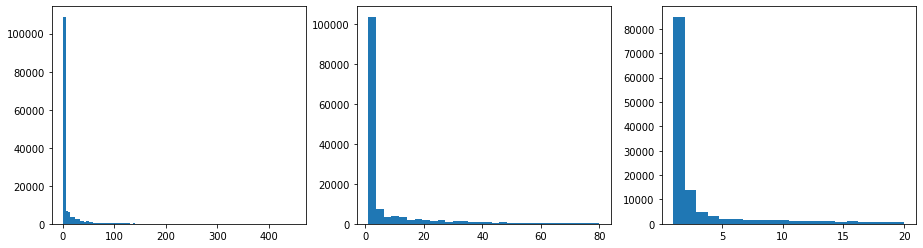

In [13]:
one_background_df = real_images_df[real_images_df.background_threshold == 1]

print("Num one background real images", one_background_df.shape[0])
all_galaxy_sizes = list(itertools.chain.from_iterable(one_background_df.cluster_sizes.tolist())) 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# fig.tight_layout()
plt.subplots_adjust(left=8.0, bottom=None, right=10.0, top=None, wspace=None, hspace=None)
ax1.hist(all_galaxy_sizes, bins=100, range=(1, 450))
ax2.hist(all_galaxy_sizes, bins=30, range=(1, 80))
ax3.hist(all_galaxy_sizes, bins=20, range=(1, 20))
plt.show()

### Distribution of number of galaxies per image
**Result 1**: The majority of the images have <= 200 clusters (93%)

**Result 2**: The prior on the number of galaxies roughly resembles a normal distribution

95.7195820694304% of images with <= 300 clusters.
93.73104145601617% of images with <= 200 clusters.
85.27131782945736% of images with <= 100 clusters.


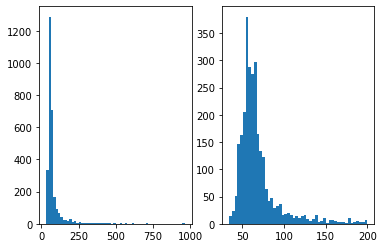

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
cluster_nums = real_images_df[real_images_df.cluster_num <= 1000].cluster_num.tolist() # get rid of outliers
restrict_on_cluster_num = [300, 200, 100]
cluster_nums_restricted_at = {num: real_images_df[real_images_df.cluster_num <= num].cluster_num.tolist()
                              for num in restrict_on_cluster_num}

for num in restrict_on_cluster_num:
    print("{}% of images with <= {} clusters.".
          format((len(cluster_nums_restricted_at[num]) / real_images_df.shape[0]) * 100, num))

ax1.hist(cluster_nums, bins=60)
ax2.hist(cluster_nums_restricted_at[200], bins=50)
plt.show()

#### How do the outliers look like ?

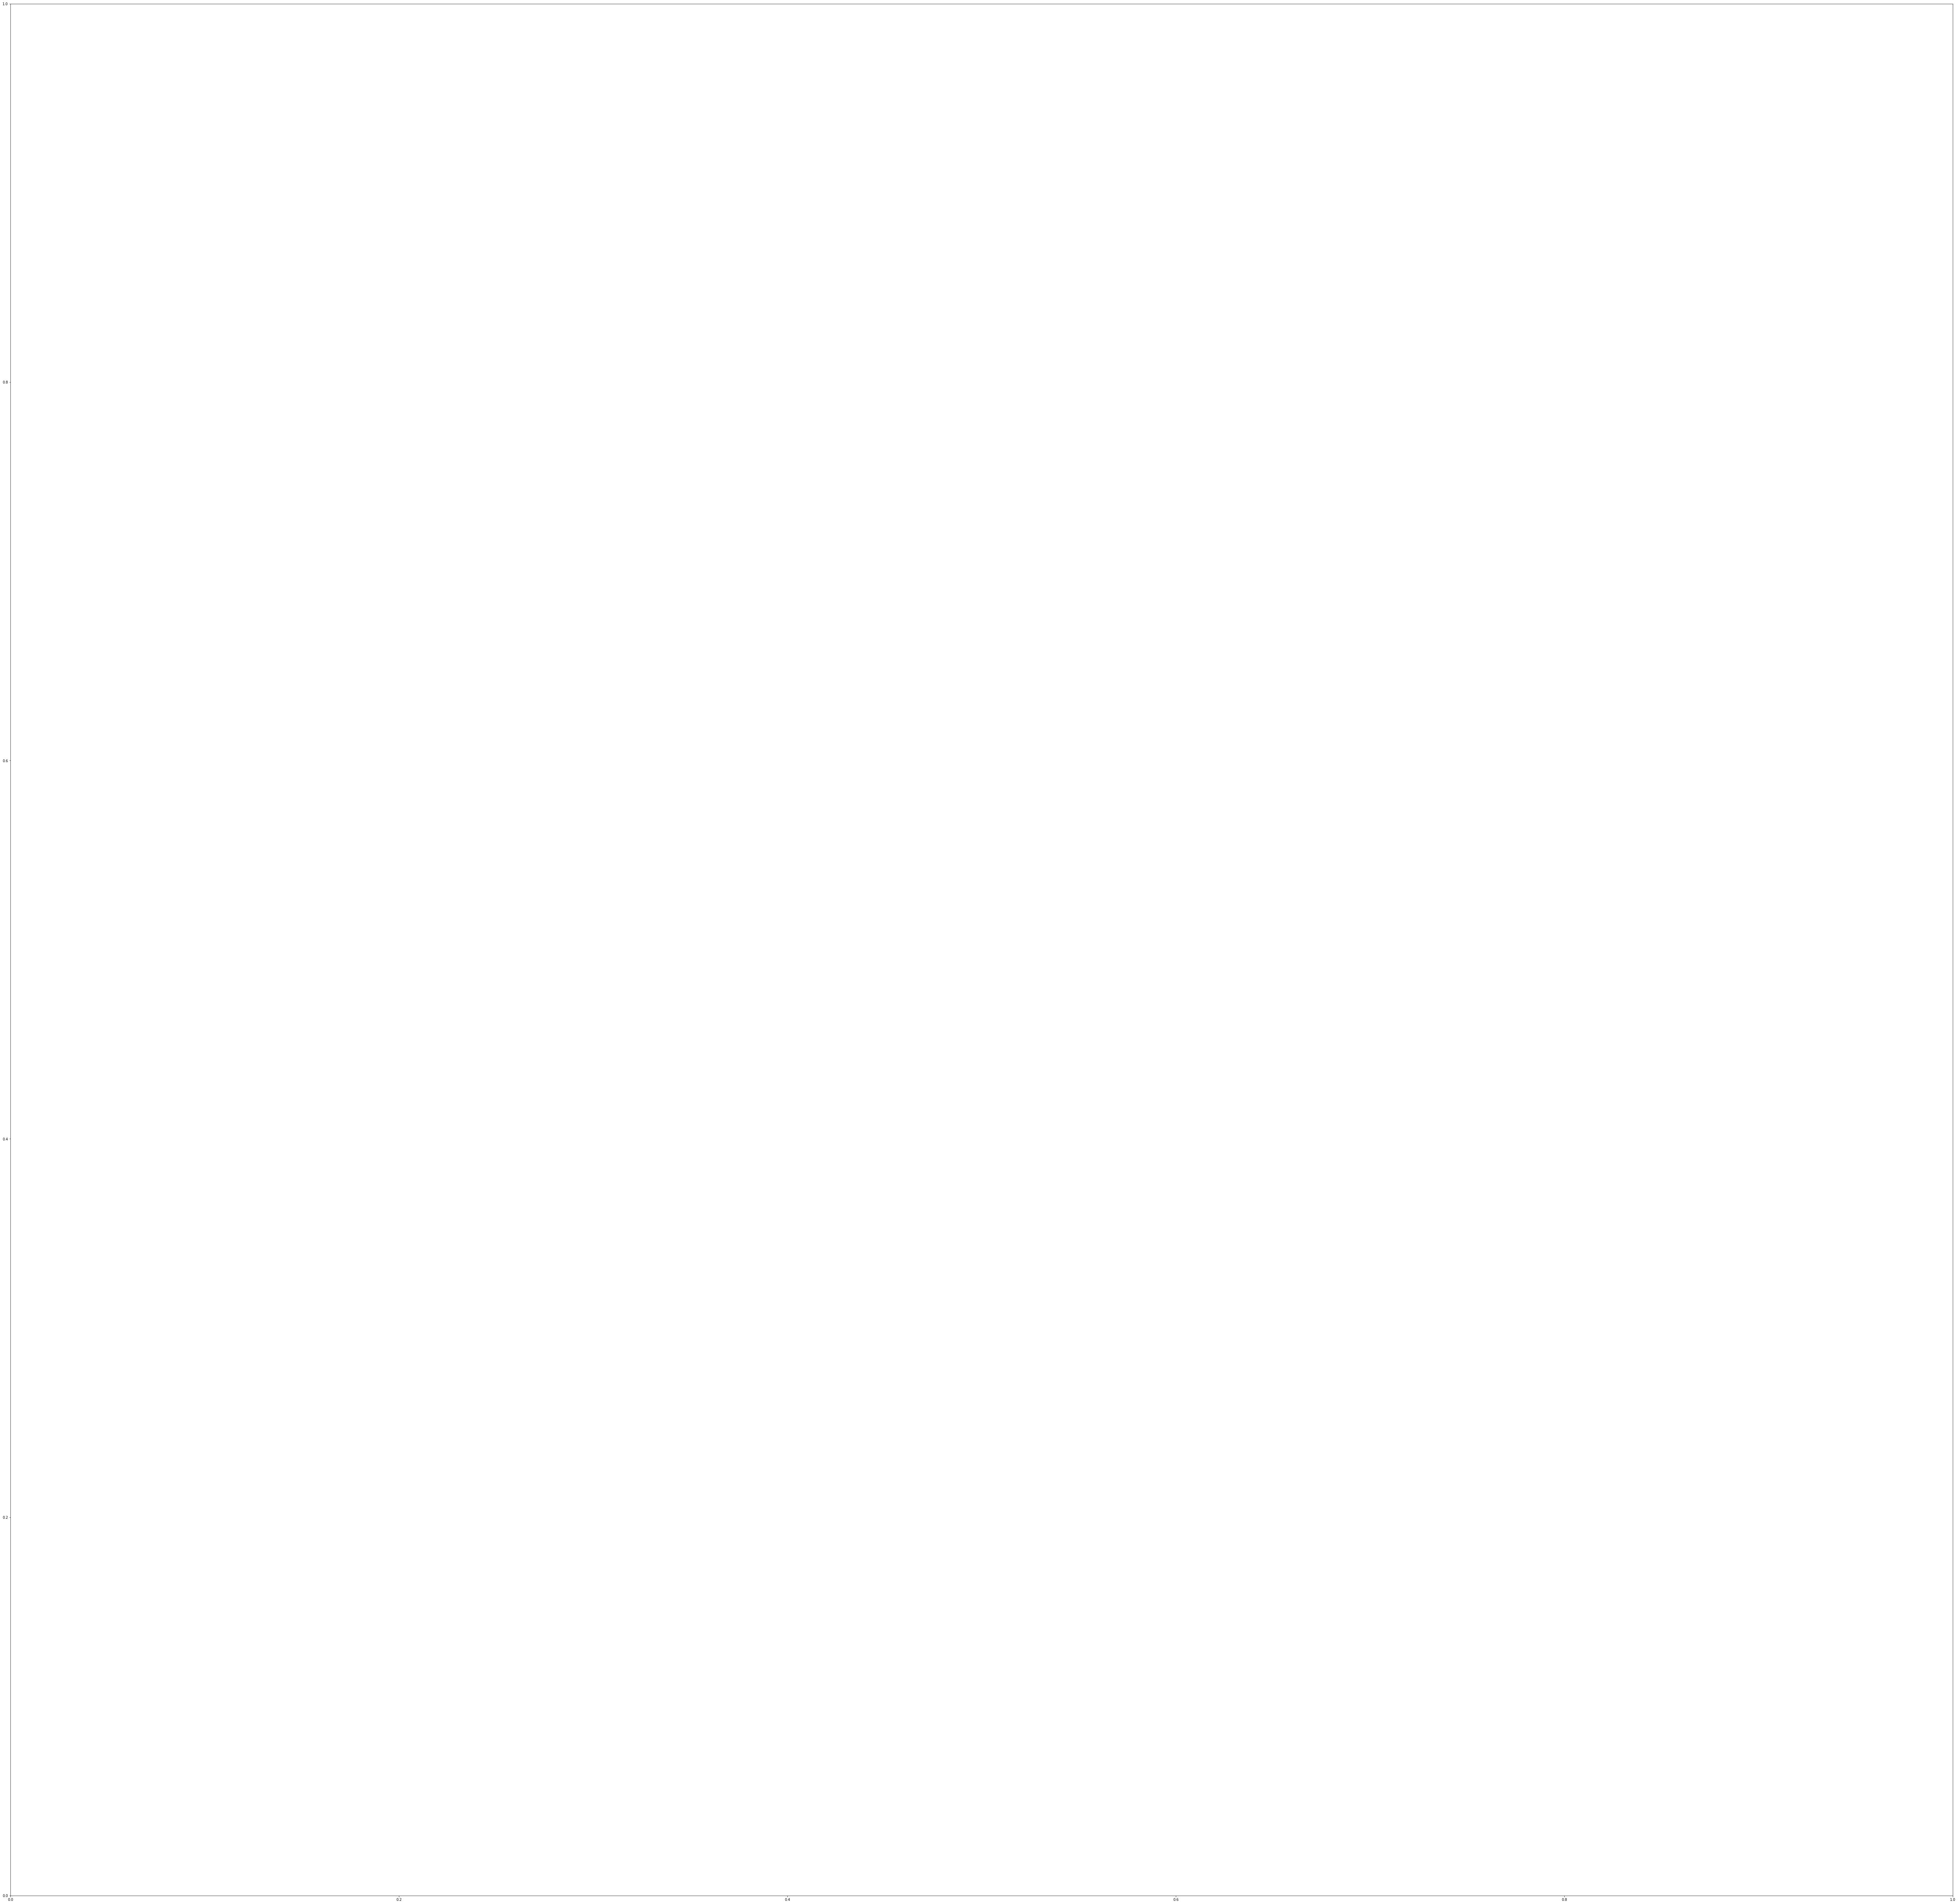

Pixel histograms:  defaultdict(<class 'int'>, {1: 63435, 0: 2928825, 2: 3567, 3: 1293, 4: 735, 5: 435, 6: 285, 7: 174, 8: 99, 10: 87, 11: 96, 17: 33, 25: 12, 30: 18, 26: 18, 20: 21, 12: 57, 9: 117, 19: 21, 36: 12, 60: 6, 75: 3, 69: 6, 47: 12, 13: 45, 66: 6, 121: 3, 163: 6, 151: 6, 96: 3, 15: 45, 38: 6, 91: 3, 179: 3, 254: 3, 236: 6, 147: 3, 67: 6, 27: 24, 14: 42, 87: 3, 176: 3, 255: 3, 241: 3, 72: 3, 29: 15, 113: 3, 157: 3, 106: 6, 54: 3, 24: 15, 16: 27, 32: 18, 55: 9, 74: 6, 53: 9, 31: 15, 23: 33, 78: 3, 82: 3, 61: 6, 35: 3, 52: 3, 81: 3, 90: 6, 71: 3, 43: 12, 21: 30, 37: 6, 59: 3, 39: 18, 34: 6, 41: 6, 40: 3, 18: 27, 22: 12, 28: 18, 45: 6, 33: 12, 42: 3, 64: 6, 152: 3, 161: 3, 48: 9, 133: 3, 253: 3, 159: 3, 68: 3, 118: 3, 207: 3, 222: 3, 143: 3, 108: 3, 116: 3, 79: 3})
Cluster sizes histogram:  Counter({1: 6342, 2: 1176, 3: 315, 4: 134, 5: 82, 6: 39, 7: 28, 8: 21, 11: 17, 9: 15, 20: 15, 10: 14, 16: 12, 21: 11, 13: 11, 14: 9, 15: 9, 25: 9, 18: 8, 33: 8, 12: 8, 17: 7, 37: 6, 23: 6, 31:

In [6]:
outlier_image_id = real_images_df[real_images_df.cluster_num > 1000].index.tolist()[0]
outlier_cluster_sizes = real_images_df.at[outlier_image_id, 'cluster_sizes']
outlier_img = cv2.imread('../data/scored/{}.png'.format(outlier_image_id))
fig, ax = plt.subplots(figsize=(100, 100))
# plt.imshow(outlier_img, cmap='gray')
plt.show()
print("Pixel histograms: ", pixel_intensity_histogram(outlier_img))
print("Cluster sizes histogram: ", Counter(outlier_cluster_sizes))

### Distribution of galaxy size

#### Result 1: A vast  majority of the clusters are actually just a single point

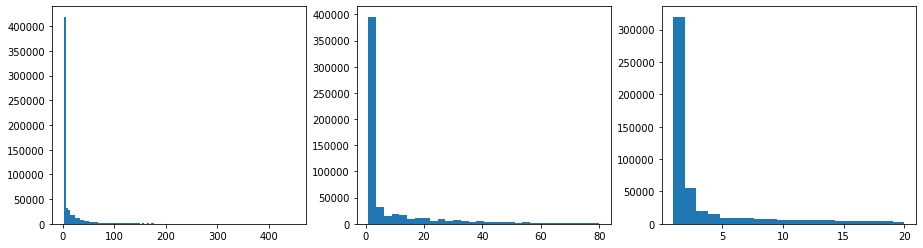

In [7]:
all_galaxy_sizes = list(itertools.chain.from_iterable(real_images_df.cluster_sizes.tolist())) 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# fig.tight_layout()
plt.subplots_adjust(left=8.0, bottom=None, right=10.0, top=None, wspace=None, hspace=None)
ax1.hist(all_galaxy_sizes, bins=100, range=(1, 450))
ax2.hist(all_galaxy_sizes, bins=30, range=(1, 80))
ax3.hist(all_galaxy_sizes, bins=20, range=(1, 20))
plt.show()

In [8]:
Counter(all_galaxy_sizes).most_common(15)

[(1, 319914),
 (2, 56063),
 (3, 19651),
 (4, 14925),
 (5, 8785),
 (6, 8683),
 (7, 8207),
 (8, 7476),
 (9, 7310),
 (10, 6151),
 (12, 5613),
 (13, 5543),
 (14, 5420),
 (11, 5266),
 (16, 4950)]

#### Result 2: Most of the single-point clusters are of intensity of only 1.

In [9]:
all_peak_intensities = np.array(list(itertools.chain.from_iterable(real_images_df.cluster_peak_intensities.tolist()))) 
all_galaxy_sizes = np.array(all_galaxy_sizes)
single_points_galaxy_indices = all_galaxy_sizes == 1

Counter(all_peak_intensities[single_points_galaxy_indices]).most_common(10)

[(1, 212001), (2, 84981), (3, 22911), (4, 21)]

#### Result 3: For both large and small clusters it is the case that most of the clusters have minimal intensity (1-5). However, this is more prominent with small clusters.

Here we try to see if there's a difference between the small clusters and the large clusters, but the difference is not very apparent. The clusters of size < 5 also have an intensity of < 5. However, a lot of the clusters of size >= 5 also have an intensity of < 5.

The threshold 5 was heuristically picked using the overall galaxy size histogram, there seems to be a jump there.

# small clusters: 410553, # all clusters: 614151
Small cluster (< 5 pixels) intensities:  [(1, 274469), (2, 106814), (3, 29217), (4, 53)]
Large cluster (>= 5 pixels) intensities:  [(1, 62712), (2, 47628), (3, 25509), (4, 11159), (5, 6870), (6, 4919), (7, 3616), (255, 2968), (8, 2772), (9, 2298)]


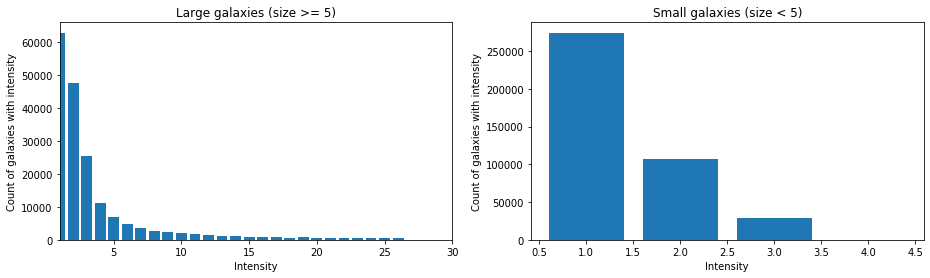

In [10]:
galaxy_size_threshold = 5
small_galaxy_size_indices = all_galaxy_sizes < galaxy_size_threshold
large_galaxy_indices = all_galaxy_sizes >= galaxy_size_threshold

print("# small clusters: {}, # all clusters: {}".format(small_galaxy_size_indices.sum(), all_galaxy_sizes.size))
small_galaxy_intensity_cnts = Counter(all_peak_intensities[small_galaxy_size_indices])
print("Small cluster (< 5 pixels) intensities: ", small_galaxy_intensity_cnts.most_common(10))
large_galaxy_intensity_cnts = Counter(all_peak_intensities[large_galaxy_indices])
print("Large cluster (>= 5 pixels) intensities: ", large_galaxy_intensity_cnts.most_common(10))
# joint_plot = sns.jointplot(all_galaxy_sizes[small_galaxy_size_indices][:100000],
#                            all_peak_intensities[small_galaxy_size_indices][:100000],
#                            kind='hex').set_axis_labels('Galaxy size', 'Peak intensity')
# ax = joint_plot.ax_joint
# ax.set(xlim=(1, galaxy_size_threshold + 1))
# ax.set(ylim=(1, 20))

fig, (ax1, ax2) = plt.subplots(1, 2)
intensity, cnt = zip(*large_galaxy_intensity_cnts.most_common(30))
ax1.bar(intensity, cnt)
ax1.set(xlim=(1, 30))
ax1.set_title('Large galaxies (size >= 5)')
ax1.set_xlabel('Intensity')
ax1.set_ylabel('Count of galaxies with intensity')
intensity, cnt = zip(*small_galaxy_intensity_cnts.most_common(20))
ax2.bar(intensity, cnt)
ax2.set_title('Small galaxies (size < 5)')
ax2.set_xlabel('Intensity')
ax2.set_ylabel('Count of galaxies with intensity')
plt.subplots_adjust(left=8.0, bottom=None, right=10.0, top=None, wspace=None, hspace=None)

plt.show()

In [ ]:
num_small_clusters = real_images_df.cluster_sizes.swifter.apply(lambda sizes: len([size for size in sizes if size < 5])).values
num_large_clusters = real_images_df.cluster_sizes.swifter.apply(lambda sizes: len([size for size in sizes if size >= 5])).values
num_very_large_clusters = real_images_df.cluster_sizes.swifter.apply(lambda sizes: len([size for size in sizes if size >= 20])).values

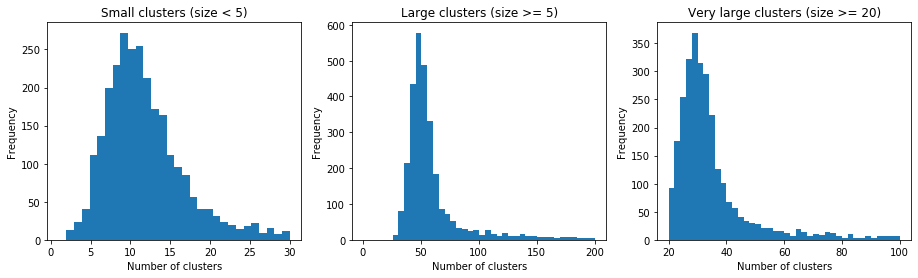

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax2.hist(num_large_clusters, bins=40, range=(1, 200))
ax2.set_title('Large clusters (size >= 5)')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Frequency')
ax1.hist(num_small_clusters, bins=30, range=(1, 30))
ax1.set_title('Small clusters (size < 5)')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Frequency')
ax3.hist(num_very_large_clusters, bins=40, range=(20, 100))
ax3.set_title('Very large clusters (size >= 20)')
ax3.set_xlabel('Number of clusters')
ax3.set_ylabel('Frequency')
plt.subplots_adjust(left=8.0, bottom=None, right=10.0, top=None, wspace=None, hspace=None)

plt.show()

### Correlation between size and intensity

* Result 1: Most of the clusters are small (<= 20) and have low intensity (<=10)
* Result 2: A general (rough) trend is size and intensity are proprotional. Mostly true for small clusters => low intensity

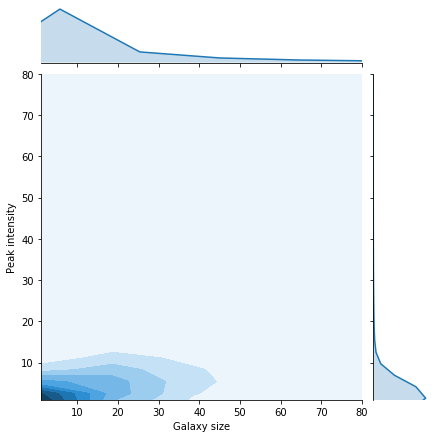

In [13]:
assert (all([x > 0 for x in all_peak_intensities]))
assert (all([x > 0 for x in all_galaxy_sizes]))
joint_plt = sns.jointplot(all_galaxy_sizes[:100000], all_peak_intensities[:100000], kind='kde')

ax = joint_plt.ax_joint
ax.set(xlim=(1, 80))
ax.set(ylim=(1, 80))
ax.set_xlabel('Galaxy size')
ax.set_ylabel('Peak intensity')
plt.show()

### How to model p(intensity) ?
A geometric distribution seems to closely resemble the prior distribution of cluster intensities.

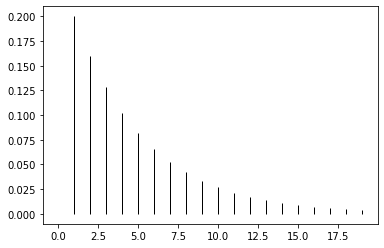

In [25]:
from scipy import stats
p = 0.2
rv = stats.geom(p)
x = list(range(20))
plt.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1)
plt.show()